# [인기도 기반 추천](https://sungkee-book.tistory.com/10)

- 머신러닝이 아닌 통계적으로 사용자들에게 좋은 평가를 받은 아이템을 추천
  - 가장 인기있는 아이템을 추천
  - 서비스 초반에 주로 활용
  > 데이터 부족하거나 추천 모델 구축이 안 되었을 때
- 개인화된 추천과 함께 인기도 기반 추천도 활용
> 단순하지만 강력하기 때문

## [인기도 score 계산법](https://velog.io/@yst3147/%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C%EC%9D%98%ED%8F%89%EA%B0%80%EC%A7%80%ED%91%9C%EC%99%80%EC%9D%B8%EA%B8%B0%EB%8F%84%EA%B8%B0%EB%B0%98%EC%B6%94%EC%B2%9C#3-%EC%9D%B8%EA%B8%B0%EB%8F%84-%EA%B8%B0%EB%B0%98-%EC%B6%94%EC%B2%9C)

- 조회수가 가장 많은 아이템 추천(Most Popular)
> ex) 뉴스 추천 -> 다른 유저들도 많은 관심을 갖는 핫한 이슈를 보고싶어 함
- 평균 평점이 가장 높은 아이템 추천(Higly Rated)
> ex) 맛집 추천 -> 평점이 높은 맛집일수록 음식이 맛있을 것이라 판단

In [3]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive
drive.mount('/content/data')

DATA_PATH = "/content/data/MyDrive/google_lecture/06. deep learning/4. RS Pytorch/data/"

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


# [Hotel Reviews](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe)

In [5]:
hotel_reviews = pd.read_csv(DATA_PATH+'Hotel Reviews/Hotel_Reviews.csv')

hotel_reviews.shape 

(515738, 17)

In [6]:
hotel_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [23]:
hotel_reviews.head(2)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968


# Most Popular

In [8]:
df_reviews = hotel_reviews.copy()
df_reviews = df_reviews[['Hotel_Name', 'days_since_review']]

print(df_reviews.shape)
df_reviews.head()

(515738, 2)


,Hotel_Name,days_since_review
0,Hotel Arena,0 days
1,Hotel Arena,0 days
2,Hotel Arena,3 days
3,Hotel Arena,3 days
4,Hotel Arena,10 days


## Hacker News Ranking Algorithm

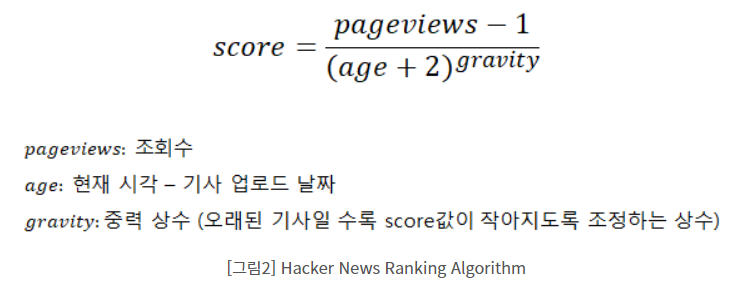

In [9]:
def hacker_news_score(pageviews, age, gravity=1.8): 
    return (pageviews - 1) / pow((age+2), gravity)

## Score 생성 

- pageviews

In [10]:
pageviews = df_reviews['Hotel_Name'].value_counts()
pageviews

Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
                                                     ... 
Ibis Styles Milano Palmanova                           12
Hotel Eitlj rg                                         12
Hotel Wagner                                           10
Mercure Paris Porte d Orleans                          10
Hotel Gallitzinberg                                     8
Name: Hotel_Name, Length: 1492, dtype: int64

- age

In [11]:
df_reviews['days_since_review'] = df_reviews['days_since_review'].map(lambda x: int(x.replace('days','').replace('day','').replace(' ','')))
df_reviews.head()

,Hotel_Name,days_since_review
0,Hotel Arena,0
1,Hotel Arena,0
2,Hotel Arena,3
3,Hotel Arena,3
4,Hotel Arena,10


In [12]:
df_reviews = df_reviews.groupby(['Hotel_Name']).agg({'days_since_review':'min'}).sort_values(by='days_since_review', ascending=False).reset_index()
df_reviews.rename(columns={'days_since_review':'age'}, inplace=True)

print(df_reviews.shape)
df_reviews.head() 

(1492, 2)


,Hotel_Name,age
0,The Principal London,366
1,Hotel Astor Saint Honor,285
2,Hotel Chavanel,149
3,Hotel Daniel Paris,146
4,Le Lavoisier,115


In [13]:
df_reviews['pageviews'] = df_reviews['Hotel_Name'].map(pageviews)

print(df_reviews.shape)
df_reviews.head()

(1492, 3)


,Hotel_Name,age,pageviews
0,The Principal London,366,1425
1,Hotel Astor Saint Honor,285,24
2,Hotel Chavanel,149,14
3,Hotel Daniel Paris,146,12
4,Le Lavoisier,115,12


In [14]:
df_reviews['score'] = df_reviews.apply(lambda row: hacker_news_score(row['pageviews'], row['age']), axis=1)

print(df_reviews.shape)
df_reviews.head()

(1492, 4)


,Hotel_Name,age,pageviews,score
0,The Principal London,366,1425,0.034276
1,Hotel Astor Saint Honor,285,24,0.000866
2,Hotel Chavanel,149,14,0.001555
3,Hotel Daniel Paris,146,12,0.001364
4,Le Lavoisier,115,12,0.002083


## 추천 

In [15]:
no_ranking = 5 # 추천 수량 

df_reviews.sort_values(by=['score'], ascending=False)[:no_ranking]

,Hotel_Name,age,pageviews,score
1312,Britannia International Hotel Canary Wharf,0,4789,1374.991931
1124,Strand Palace Hotel,0,4256,1221.927875
1030,Park Plaza Westminster Bridge London,0,4169,1196.943686
1291,Copthorne Tara Hotel London Kensington,0,3578,1027.223504
1176,DoubleTree by Hilton Hotel London Tower of London,0,3212,922.117604


# Higly Rated

In [16]:
df_reviews = hotel_reviews.copy()
df_reviews = df_reviews[['Hotel_Name', 'Reviewer_Score']]

print(df_reviews.shape)
df_reviews.head()

(515738, 2)


,Hotel_Name,Reviewer_Score
0,Hotel Arena,2.9
1,Hotel Arena,7.5
2,Hotel Arena,7.1
3,Hotel Arena,3.8
4,Hotel Arena,6.7


## Steam Rating Algorithm

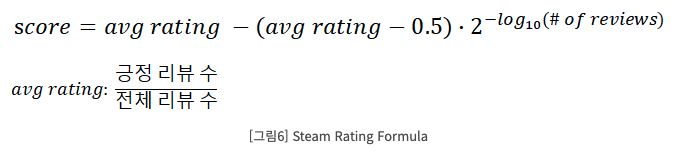

In [17]:
import numpy as np 

def GetRating(positiveVotes, negativeVotes, standard_score=0.5): 
    totalVotes = positiveVotes + negativeVotes 
    average = positiveVotes/totalVotes 
    score = average - ( average - standard_score )*2**(-np.log10(totalVotes + 1)) 
    return score * 100

## Score 생성 

In [18]:
df_score_max = df_reviews.groupby(['Hotel_Name']).agg({'Reviewer_Score':'max'}).reset_index()
df_score_max.rename(columns={'Reviewer_Score':'score_max'}, inplace=True)

df_score_max.head()

,Hotel_Name,score_max
0,11 Cadogan Gardens,10.0
1,1K Hotel,10.0
2,25hours Hotel beim MuseumsQuartier,10.0
3,41,10.0
4,45 Park Lane Dorchester Collection,10.0


In [19]:
df_score_min = df_reviews.groupby(['Hotel_Name']).agg({'Reviewer_Score':'min'}).reset_index()
df_score_min.rename(columns={'Reviewer_Score':'score_min'}, inplace=True)

df_score_min.head()

,Hotel_Name,score_min
0,11 Cadogan Gardens,4.2
1,1K Hotel,3.8
2,25hours Hotel beim MuseumsQuartier,2.5
3,41,6.7
4,45 Park Lane Dorchester Collection,8.3


In [20]:
df_score = pd.merge(df_score_max, df_score_min, on='Hotel_Name', how='inner')

df_score.head()

,Hotel_Name,score_max,score_min
0,11 Cadogan Gardens,10.0,4.2
1,1K Hotel,10.0,3.8
2,25hours Hotel beim MuseumsQuartier,10.0,2.5
3,41,10.0,6.7
4,45 Park Lane Dorchester Collection,10.0,8.3


In [21]:
df_score['score'] = df_score.apply(lambda row: GetRating(row['score_max'], row['score_min']), axis=1)

df_score.head()

,Hotel_Name,score_max,score_min,score
0,11 Cadogan Gardens,10.0,4.2,61.420530
1,1K Hotel,10.0,3.8,62.482201
2,25hours Hotel beim MuseumsQuartier,10.0,2.5,66.295699
3,41,10.0,6.7,55.720271
4,45 Park Lane Dorchester Collection,10.0,8.3,52.739451


## 추천 

In [22]:
no_ranking = 5 # 추천 수량 

df_score.sort_values(by=['score'], ascending=False)[:no_ranking]

,Hotel_Name,score_max,score_min,score
1358,The Levante Parliament A Design Hotel,10.0,2.5,66.295699
718,Hotel Okura Amsterdam,10.0,2.5,66.295699
1311,The Bailey s Hotel London,10.0,2.5,66.295699
1310,The Athenaeum,10.0,2.5,66.295699
705,Hotel Miramar Barcelona GL,10.0,2.5,66.295699
